# Motif enrichment analysis

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "./scripts")
import functions as f
from matplotlib import pyplot as plt
import seaborn as sns
from copy import copy
import multiprocessing as mp
import joblib
from tqdm import tqdm
from scipy import stats

In [2]:
cfg = f.get_actual_parametrization("./config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


### Motifs library

There are conventional denotations for all possible triads as presented below

<img src="./pics/triads.png" width=2000 height=20/>

# Yeast Tnet

In [3]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "yeast")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


In [4]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [5]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)
counter_orig

CPU times: user 2.63 s, sys: 141 ms, total: 2.77 s
Wall time: 8.6 s


{'021C': 37631, '021D': 1059856, '021U': 26042, '030C': 8, '030T': 3370}

#### Random networks motif counting

In [12]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 60000
counters = f.generate_random_networks(cfg, interaction_matrix, N_SIMS, N_STEPS, N_SWAPS)
# joblib.dump(counters, "./networks/yeast/shuffled_counters.gz");

100%|██████████| 100/100 [15:10<00:00,  9.10s/it]


#### Z-score and P-value estimation

In [6]:
counters = joblib.load("./networks/yeast/shuffled_counters.gz");

100%|██████████| 1000/1000 [00:03<00:00, 254.09it/s]


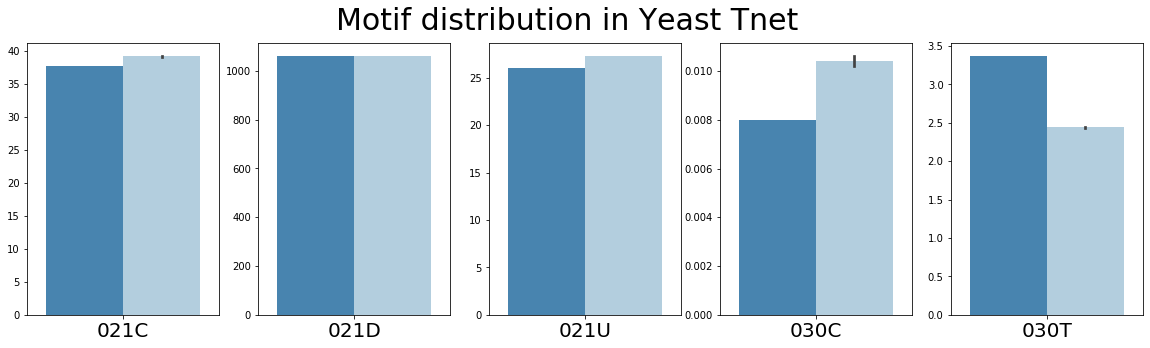

In [7]:
f.plot_distr(counters, counter_orig, label="Motif distribution in Yeast Tnet", highlight=False);

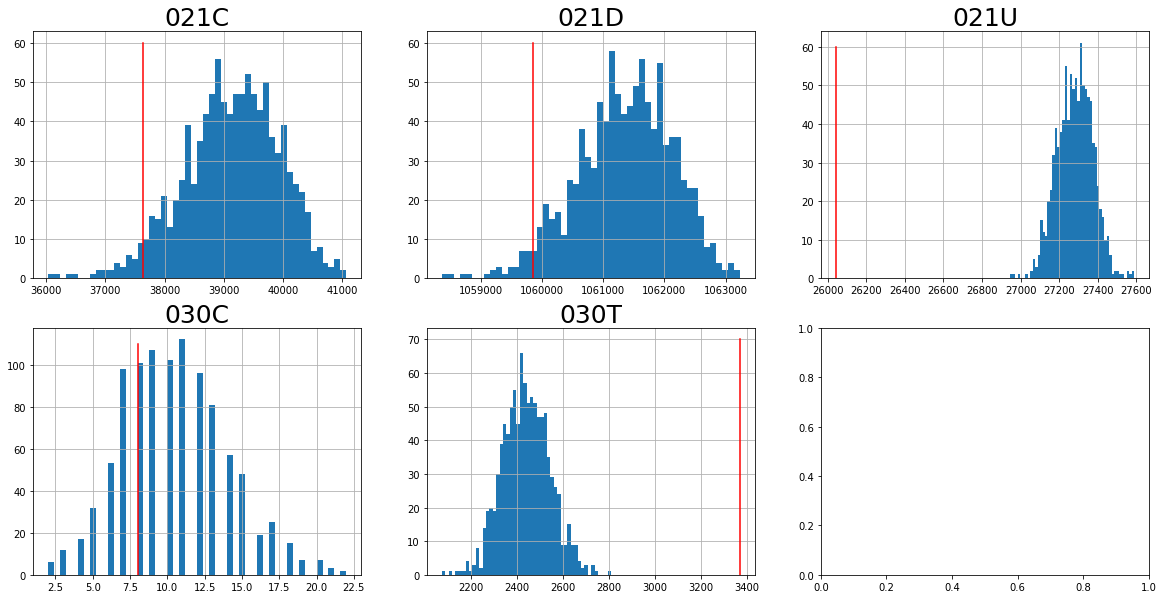

In [8]:
f.plot_distr_2(counters, counter_orig, ticks = [60, 60, 60, 110, 70])

In [9]:
f.build_zscores_report(counters, counter_orig)

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,37631,39133.2,798.108,-1.88218,0.036,non-significant
021D,1059856,1.06136e+06,775.767,-1.94061,0.032,non-significant
021U,26042,27282.5,91.95,-13.4915,0,< 0.01
030C,8,10.405,3.54753,-0.677936,0.319,non-significant
030T,3370,2439.5,102.095,9.11403,0,< 0.01


# Ecoli Tnet

In [10]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "ecoli")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: ecoli


In [11]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [12]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)
counter_orig

CPU times: user 817 ms, sys: 99.9 ms, total: 917 ms
Wall time: 3.23 s


{'021C': 3938, '021D': 329287, '021U': 4365, '030C': 0, '030T': 1392}

#### Random networks motif counting

In [6]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 70000
counters = f.generate_random_networks(cfg, interaction_matrix, N_SIMS, N_STEPS, N_SWAPS)
# joblib.dump(counters, "./networks/ecoli/shuffled_counters.gz");

#### Z-score and P-value estimation

In [13]:
counters = joblib.load("./networks/ecoli/shuffled_counters.gz");

100%|██████████| 1000/1000 [00:03<00:00, 256.02it/s]


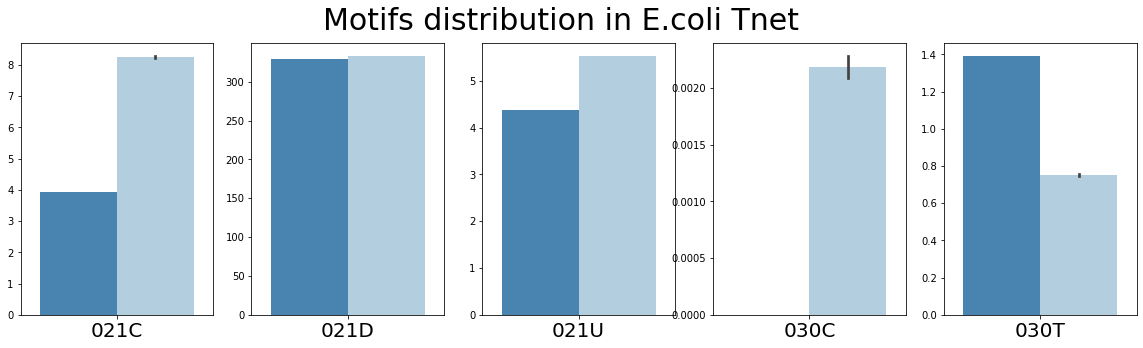

In [14]:
df, fig = f.plot_distr(counters, counter_orig, label="Motifs distribution in E.coli Tnet", highlight=False);

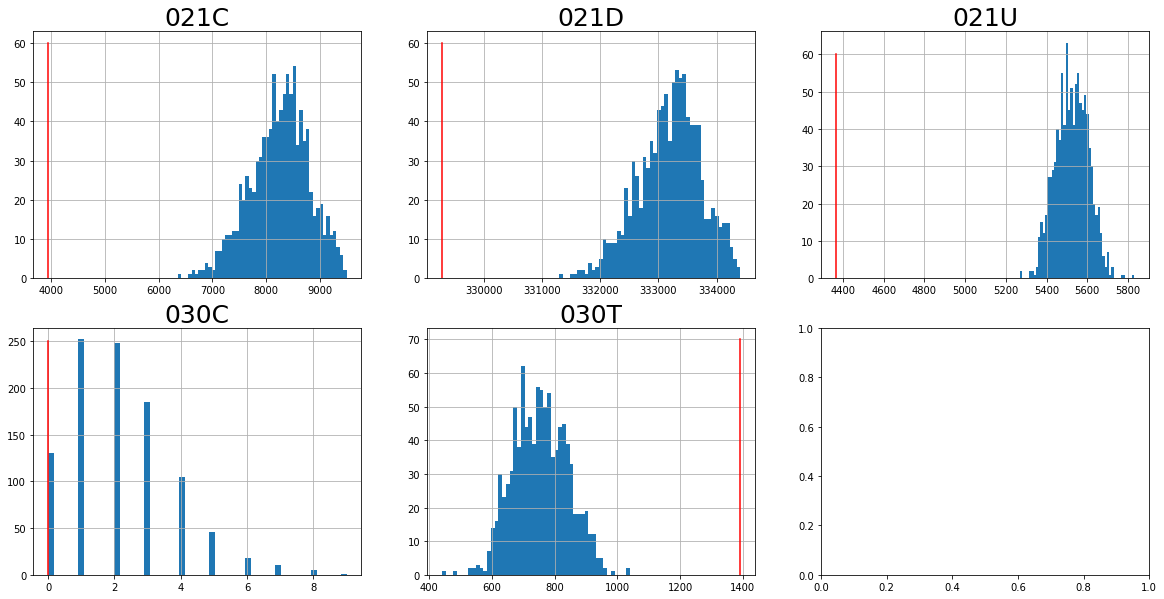

In [16]:
f.plot_distr_2(counters, counter_orig, ticks = [60, 60, 60, 250, 70])

In [17]:
f.build_zscores_report(counters, counter_orig)

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,3938,8250.95,544.278,-7.92417,0,< 0.01
021D,329287,333191,537.226,-7.26617,0,< 0.01
021U,4365,5524.94,79.8659,-14.5235,0,< 0.01
030C,0,2.18,1.58921,-1.37175,0.13,non-significant
030T,1392,754.326,86.0515,7.41038,0,< 0.01


# GS 0.1 net

In [18]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "gs0.1")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: gs0.1


In [19]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [20]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)
counter_orig

CPU times: user 46.4 ms, sys: 49.8 ms, total: 96.1 ms
Wall time: 2.22 s


{'021C': 9459, '021D': 5261, '021U': 4079, '030C': 17, '030T': 73}

#### Random networks motif counting

In [6]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 40000
counters = f.generate_random_networks(cfg, interaction_matrix, N_SIMS, N_STEPS, N_SWAPS)
# joblib.dump(counters, "./networks/gs0.1/shuffled_counters.gz");

#### Z-score and P-value estimation

In [21]:
counters = joblib.load("./networks/gs0.1/shuffled_counters.gz");

100%|██████████| 1000/1000 [00:04<00:00, 245.88it/s]


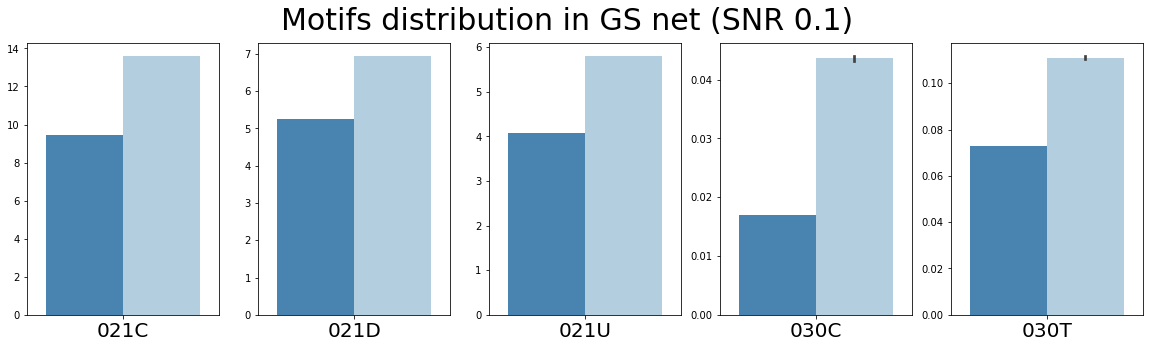

In [22]:
f.plot_distr(counters, counter_orig, label="Motifs distribution in GS net (SNR 0.1)", highlight=False);

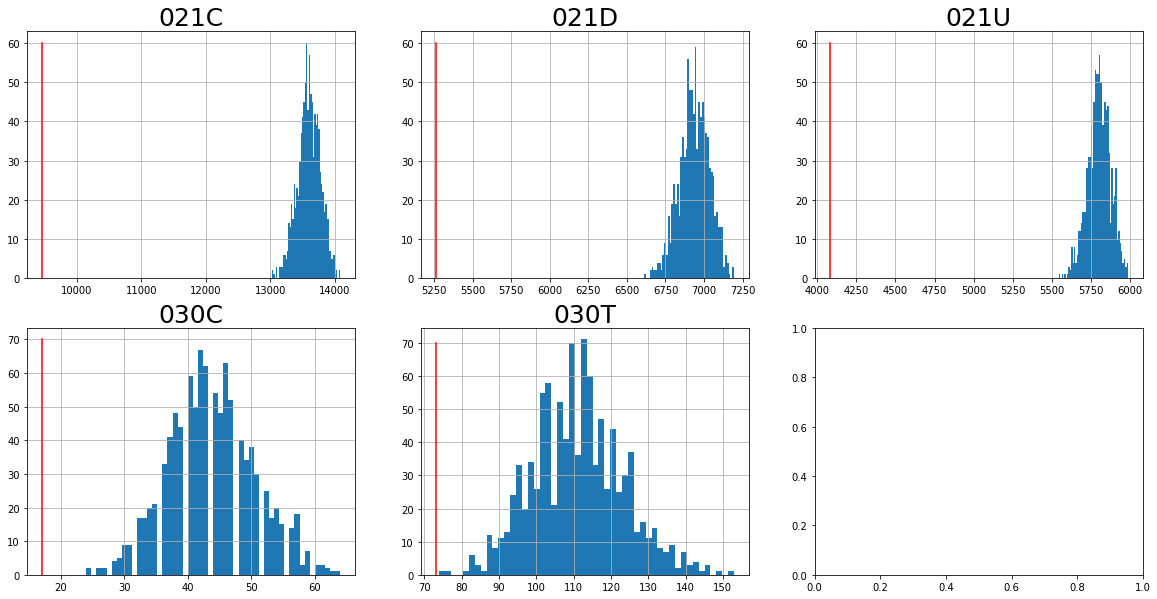

In [26]:
f.plot_distr_2(counters, counter_orig, ticks = [60, 60, 60, 70, 70])

In [27]:
f.build_zscores_report(counters, counter_orig)

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,9459,13594.9,175.585,-23.5552,0,< 0.01
021D,5261,6937.75,97.3987,-17.2153,0,< 0.01
021U,4079,5801.72,73.102,-23.566,0,< 0.01
030C,17,43.626,6.80824,-3.91085,0,< 0.01
030T,73,111.069,12.1616,-3.13027,0,< 0.01
